# Prior free Bayesian estimation

Additive Gaussian Noise model for the likelihood is known

$$Y = X + W$$

$$W \sim \mathcal{N}(0, \sigma^2)$$

So, we know that

$$P_{Y|X} (y|x) = \exp \big({-\frac{(y-x)^2}{2 \sigma^2}}\big)$$

We also receive i.i.d samples $Y_i$. We **do not** know the prior distribution $P_X$ of $X$.

Goal: Obtain the minimum mean square estimator of $X$ given $Y$.

## Maximum Likelihood Estimation

MLE is the following estimator:

$$\hat X (y) = \text{argmax}_x \log P_{Y|X}(y|x)$$

which is given by 

$$\hat X(y) = y$$

for the additive Gaussian noise model.

In [1]:
from pylab import *

In [180]:
import scipy.stats as st
from tqdm import tqdm_notebook, tqdm

In [19]:
rv.rvs(10)

array([0.04152018, 0.20721262, 0.93354098, 0.45503384, 0.5313189 ,
       0.02197229, 0.13410804, 0.13365639, 0.6617916 , 0.12434364])

In [2]:
rcParams['figure.figsize'] = 12,9
rcParams['axes.grid'] = True
rcParams['font.size'] = 18
rcParams['figure.facecolor'] = 'w'

In [85]:
def getXY(n, sigma=0.1, prior=st.uniform()):
    x = prior.rvs(n)
    noise = st.norm(loc=0, scale=sigma).rvs(n)
    y = x+noise
    return x, y

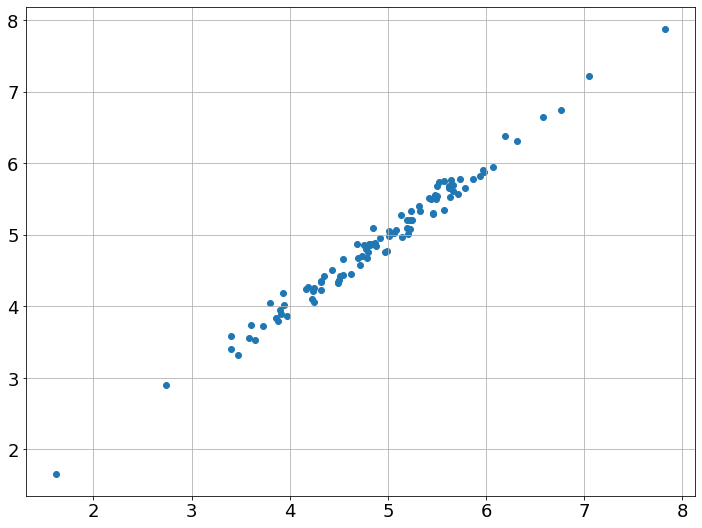

In [86]:
mu0 = 5
sigma0 = 1
scatter(*getXY(100, sigma=0.1, prior=st.norm(loc=mu0, scale=sigma0)))

In [108]:
import scipy.optimize as opt

# SURE Estimator for Prior-free Bayes

In [167]:
def sure_estimator(y, sigma, debug=False):
    def loss(theta):
        # using model g_theta(y) = ay + b (we know the answer is linear for gauss prior, but in general we can put neural network)
        # theta = [a,b]
        a, b = theta
        return ((a*y + b)**2 + (sigma**2*a)).mean()
    
    def loss_jac(theta):
        # finding derivatives by hand in 2020 is shameless but i did it
        a, b = theta
        da = (2*(a*y + b)*y + sigma**2).mean()
        db = (2*(a*y + b)).mean()
        return array([da, db])
    
    opt_result = opt.minimize(loss, x0=randn(2), jac=loss_jac)
    if debug:
        print(opt_result)
    aa, bb = opt_result.x
    
    def est(y):
        return y + (aa*y + bb)
    
    return est

In [168]:
mu0 = 5
sigma0 = 1
sigma = 0.1
x, y = getXY(10000, sigma=sigma, prior=st.norm(loc=mu0, scale=sigma0))
k = (sigma0**2)/(sigma**2 + sigma0**2)
def loss(theta):
    a, b = theta
    return ((a*y + b)**2 + sigma**2*a).mean()

In [169]:
est = sure_estimator(y, sigma, debug=True)
print(k, (1-k)*mu0)
print(loss((k-1, (1-k)*mu0)))

      fun: -2.5024808355544692e-05
 hess_inv: array([[ 0.50045418, -2.50104705],
       [-2.50104705, 12.99744789]])
      jac: array([1.23807772e-06, 2.40152357e-07])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([-0.00500494,  0.02500994])
0.9900990099009901 0.04950495049504955
-1.0766103243721289e-06


In [181]:
mu0 = 5
sigma0 = 1
prior = st.norm(loc=mu0, scale=sigma0)
sigma = 1
ns = 10**arange(2,8)

repeats = 10

all_mle_errs = zeros((repeats, len(ns)))
all_bls_errs = zeros((repeats, len(ns)))
all_sure_errs = zeros((repeats, len(ns)))

for i in tqdm(range(repeats)):
    mle_errs = all_mle_errs[i]
    bls_errs = all_bls_errs[i]
    sure_errs = all_sure_errs[i]

    for j, n in enumerate(ns):
        x, y = getXY(n, sigma=sigma, prior=prior)
        mle = y
        mle_err = ((mle-x)**2).mean()
        mle_errs[j] = (mle_err)

        k = (sigma0**2)/(sigma**2 + sigma0**2)
        bls = k*y + (1-k)*mu0
        bls_err = ((bls-x)**2).mean()
        bls_errs[j] = (bls_err)

        est = sure_estimator(y, sigma)
        sure_err = ((est(y) - x)**2).mean()
        sure_errs[j] = (sure_err)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.05s/it]


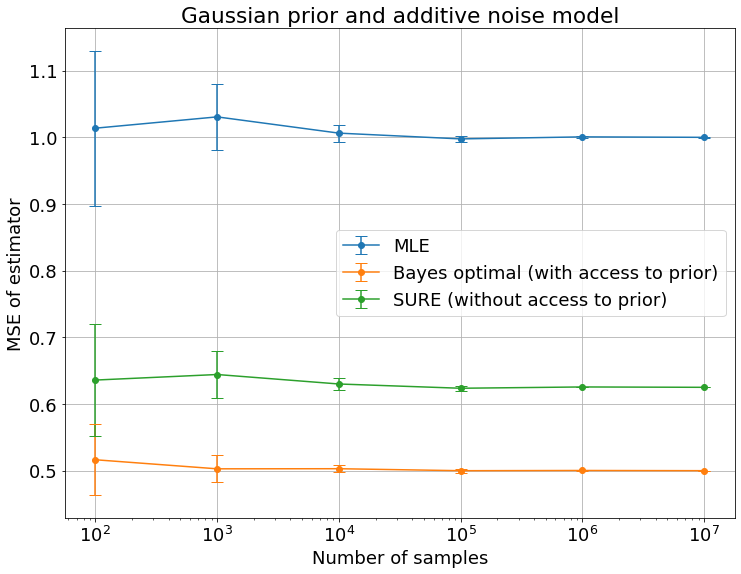

In [194]:
semilogx()
errorbar(ns, all_mle_errs.mean(axis=0), yerr=all_mle_errs.std(axis=0), capsize=6, marker='o', label='MLE')
errorbar(ns, all_bls_errs.mean(axis=0), yerr=all_bls_errs.std(axis=0), capsize=6, marker='o', label='Bayes optimal (with access to prior)')
errorbar(ns, all_sure_errs.mean(axis=0), yerr=all_sure_errs.std(axis=0), capsize=6, marker='o', label='SURE (without access to prior)')
xlabel("Number of samples")
ylabel("MSE of estimator")
title("Gaussian prior and additive noise model")
legend()
savefig("figs/gauss_linsure.png", bbox_inches='tight')
show()

# Empirical Bayes using Conjugate Prior

* Find conjugate prior parameters by MLE
* Use this to calculate BLS

# SURE using Neural Network